## Exercise 2

### [ 1 ] Load the Data

In [2]:
import numpy as np
import pandas as pd
from scipy import stats as st
import math
import igraph as ig
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


In [3]:
asd = pd.read_csv('asd_data.csv')
td = pd.read_csv('td_data.csv')

print(f"ASD's dataset shape : {asd.shape}")
print(f"TD's dataset shape : {td.shape}")

ASD's dataset shape : (145, 116)
TD's dataset shape : (145, 116)


In [4]:
# Checking for presence of missing values
print("No missing values for TD") if all(td.isna().sum() == 0)  else -1
print("No missing values for ASD") if all(asd.isna().sum() == 0)  else -1

No missing values for TD
No missing values for ASD


### [ 2 ] Estimates

In [13]:
def estimateGraph (df, T = .4, B = 500, alpha = .05, bonf = True, seed = 1997, method = "normal" ) :
 
    __methodList = ['normal', 'percentile']

    method = method.lower()

    if method not in __methodList : 
        raise Exception(f"MethodNotFoundException ... \nAvaialble methods : {__methodList} ")

    # Fixing seed for reproducibilty
    np.random.seed(seed)

    # n : Number of observations
    # D : Number of ROIs 
    n, D = df.shape

    # Dealing with multiplicity using Bonferroni correction
    if bonf : 
        alpha /= math.comb(D,2)
    
    # Gaussian Standard Quantile
    gaussianQuantile = st.norm.ppf(1 - alpha/2)

    # Plug in Estimator
    hat_rho = df.corr().to_numpy()
    
    # Initalize D x D x B np.array\\
    bootStat = np.zeros((D, D, B))

    # Non-parametric Bootstraped pearson correlation coefficent 
    for b in range(B) : 
        xBoot = df.sample(n = len(df), replace = True)
        bootStat[:,:,b] = xBoot.corr()

    # Initializing a DxD adjacency matrix 
    adj_matrix = np.zeros((D, D))

    for i in range(D) : 
        for j in range(D) : 
            # Skip the diagonal
            if i == j : 
                continue

            if method == 'normal' : 
            # Normal confidence interval
                CI = hat_rho[i,j] + np.array((-1,+1))*gaussianQuantile*bootStat[i,j,...].std()
            elif method == 'percentile' : 
                lw = np.quantile(bootStat[i,j,...], q = alpha/2)
                up = np.quantile(bootStat[i,j,...], q = 1 - alpha/2)
                CI = np.array((lw,up))

            # Intersection of ranges : If there is no intersection place edge
            if not ( CI[1] >= -abs(T) and abs(T) >= CI[0] ) :
                adj_matrix[i,j] = 1
     
    return adj_matrix
            

### [ 3 ] Visualization [T = .4 | arbitrary choice]

We chose the circular layout since in the documentation is the only one presented as deterministic

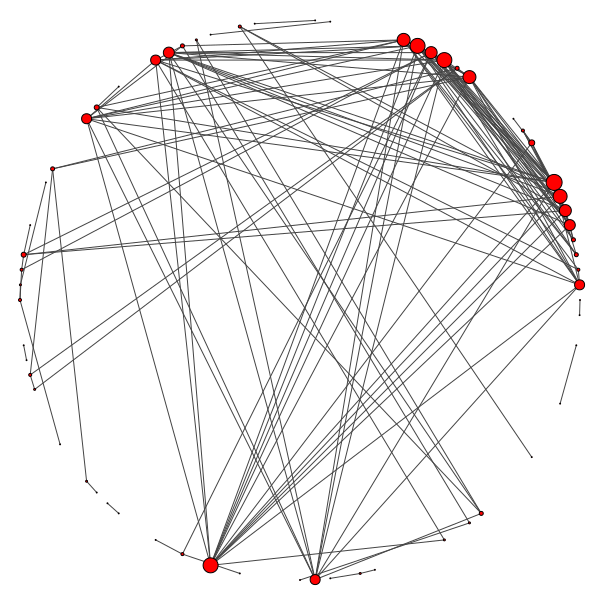

In [14]:
# ASD Dataset
asdAdjMatrix = estimateGraph(asd)
g = ig.Graph.Adjacency(asdAdjMatrix, mode = 'undirected')
ig.plot(
    g,
    layout = 'circle', # Deterministic
    vertex_size = g.degree()

)

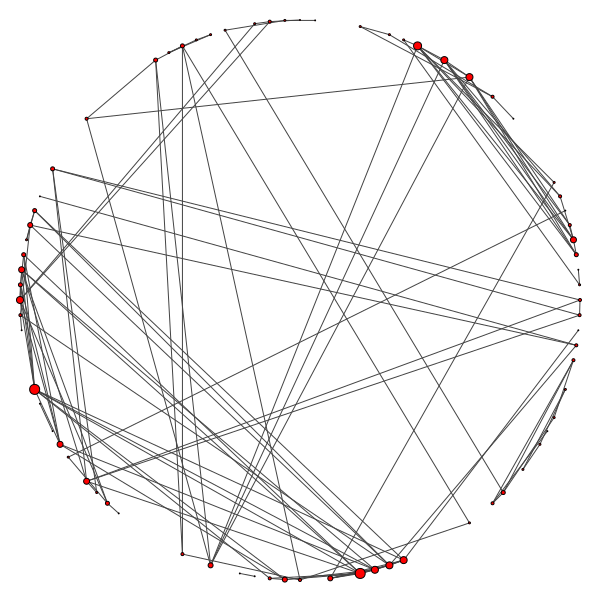

In [15]:
# TD Dataset
# ASD Dataset
tdAdjMatrix = estimateGraph(td)
g = ig.Graph.Adjacency(tdAdjMatrix, mode = 'undirected')
ig.plot(
    g,
    layout = 'circle', # Deterministic
    vertex_size = g.degree()

)

### [ 4 ] Analysis

Following is the legend of the Regions of intrest

![regions](./imgs/regions.PNG)

![img1](./imgs/brainlegen.png)

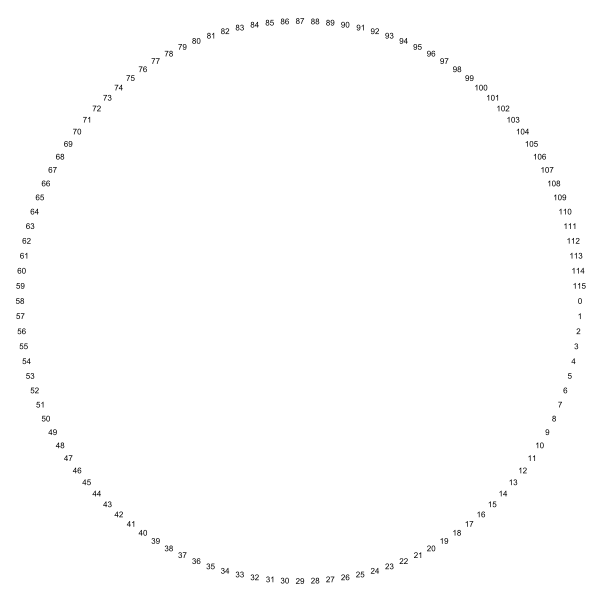

In [17]:
# TD Dataset
# ASD Dataset
tdAdjMatrix = estimateGraph(td)
g = ig.Graph.Adjacency(tdAdjMatrix, mode = 'undirected')
ig.plot(
    g,
    layout = 'circle', # Deterministic
    vertex_label = [_ for _ in range(116)],
    vertex_size = 0,
    edge_width = 0, 
    vertex_label_size = 8

)

#### [ 4.1 ] Color map and labeling

In [18]:
numberOfROI = 116


legendDict = {}
legend = open('legend.txt', 'r')

for line in legend : 
    # Weird and not so efficent string work ... only 116 lines i can take the disadvantage
    line = line.split(" ")                         # XX region name
    line = line[0] + " " + "_".join(line[1:][:-1]) # XX region_name
    line = line.split(" ")                         # [XX, region_name]
    legendDict[line[0]] = line[1].split("_")[0]

# Using seaborn to generate color palette ([0,1] x 3)
palette = sns.color_palette("Spectral", len(set(legendDict.values())))

# Building the color map
i = 0
colorMap = {}
for k, v in legendDict.items():
    if colorMap.get(v) == None: 
        colorMap[v] = palette[i]
        i += 1 

In [19]:
def getVisualStyle(g) : 

    visualStyle = {}
    #visualStyle["vertex_label"] =  [legendDict[str(x)] for x in range(1, numberOfROI + 1)]
    visualStyle["layout"] = 'circle'
    visualStyle["vertex_size"] = g.degree()
    visualStyle["vertex_color"] = [colorMap[legendDict[str(x)]] for x in range(1, numberOfROI + 1)] 
    return visualStyle

We have decided to group ROIs based on their name provided in the ATLAS table above. We found out 33 diffrent categories. We noticed that they do not keep in count left and right emisphere but they do a good job with front middle and back part of the brain

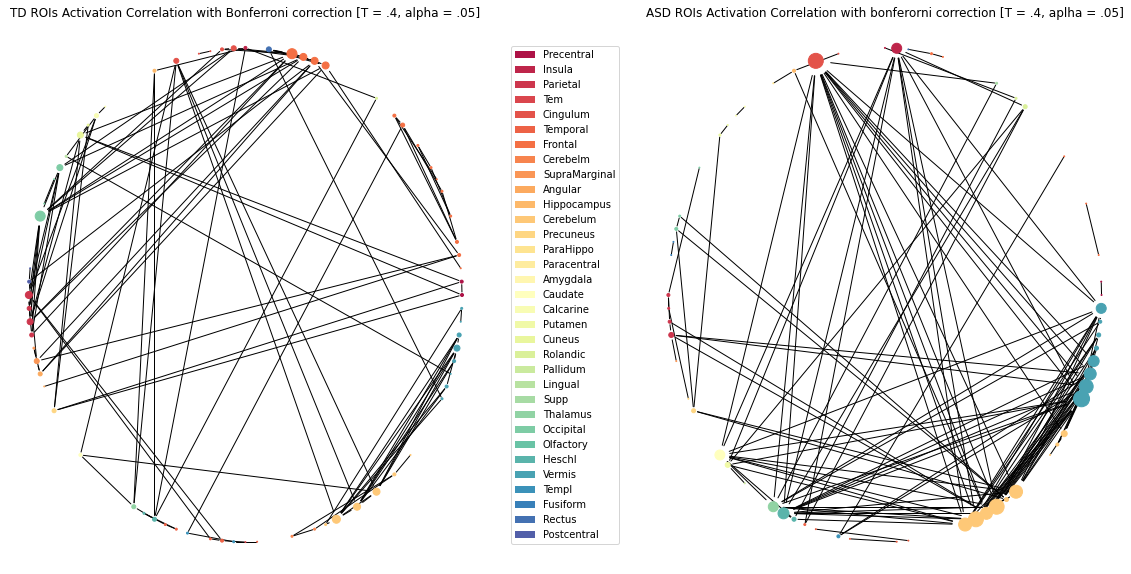

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,10), gridspec_kw={'width_ratios' : [15,1,15]})

ax[0].set_title("TD ROIs Activation Correlation with Bonferroni correction [T = .4, alpha = .05]")
ax[2].set_title("ASD ROIs Activation Correlation with bonferorni correction [T = .4, aplha = .05]")

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')


legend_elements = [Patch(facecolor=colorMap[str(x)], label = str(x)) for x in colorMap.keys()]

ax[1].legend(handles=legend_elements, loc='center')

g = ig.Graph.Adjacency(tdAdjMatrix, mode = 'undirected')
visualStyle = getVisualStyle(g)
ig.plot(g, **visualStyle, target = ax[0] )


g = ig.Graph.Adjacency(asdAdjMatrix, mode = 'undirected')
visualStyle = getVisualStyle(g)
ig.plot(g, **visualStyle, target=ax[2])

NOTE : 
* The bigger point means a higher degree of that node/ROI that is a high correlation with multiple ROIs

